# Read Train and Test dataset

In [1]:
train_files = []
y_train = []

path = "data/"
f = open('training_list.txt','r')

for line in f:
    train_path = line.split("\n")
    train_files.append(path + train_path[0]) 
    label = line.split("/")
    y_train.append(label[0])

f.close()

In [105]:
test_files = []
y_test = []

f = open("testing_list.txt", 'r')

for line in f:
    test_path = line.split("\n")
    test_files.append(path + test_path[0]) 
    label = line.split("/")
    y_test.append(label[0])

f.close()

In [106]:
y_test

['right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',


In [64]:
import librosa
import os

X_train=[]
X_test=[]



373

In [4]:
len(train_files)

11005

In [5]:
len(test_files)

9981

# Convertion

In [6]:
import numpy as np
import librosa.display
import matplotlib.pyplot as plt

hop_length = 512
window_size = 1024
window = np.hanning(window_size)

#https://stackoverflow.com/questions/52432731/store-the-spectrogram-as-image-in-python

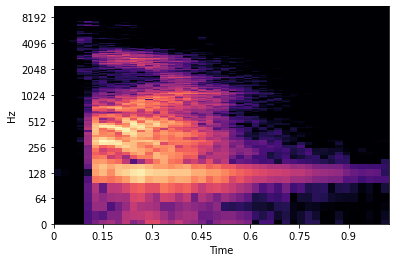

In [7]:
#convert the training audios to spectograms and place it in the Xtrain variable
for fileName in train_files:
    y,sr=librosa.load(fileName) #load the file
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=128)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    X_train.append(spectrogram)

#print out the spectrogram
out  = librosa.core.spectrum.stft(y, n_fft = window_size, hop_length = hop_length, window=window)
out = 2 * np.abs(out) / np.sum(window)
librosa.display.specshow(librosa.amplitude_to_db(out,ref=np.max), y_axis='log', x_axis='time')

In [9]:
len(X_train)

11005

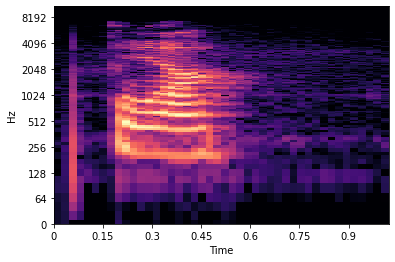

In [10]:
#convert the testing audios to spectograms and place it in the Xtest variable
for fileName in test_files:
    y,sr=librosa.load(fileName) #load the file
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=128)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    X_test.append(spectrogram)

out  = librosa.core.spectrum.stft(y, n_fft = window_size, hop_length = hop_length, window=window)
out = 2 * np.abs(out) / np.sum(window)

librosa.display.specshow(librosa.amplitude_to_db(out,ref=np.max), y_axis='log', x_axis='time')

In [19]:
len(X_test)
y_train[0]

'right'

# Spectrogram

### Train

In [38]:
#save up the spectrogram images in the test folder for training the model

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
imageNo = 1
for fileName in test_files:
    #write something like count number of files in a label folder and run a loop placing all those images in that folder
    y,sr=librosa.load(fileName) #load the file
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=128)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    
    out  = librosa.core.spectrum.stft(y, n_fft = window_size, hop_length = hop_length, window=window)
    out = 2 * np.abs(out) / np.sum(window)

    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(111)
    p = librosa.display.specshow(librosa.amplitude_to_db(out, ref=np.max), ax=ax, y_axis='log', x_axis='time')
    
    label = fileName.split("/")
    path = 'images/test/{0}/'.format(label[1]) 

    #downloading few spectrogram images
    fig.savefig(path + str(imageNo) + '.png')
    imageNo += 1

### Test

In [37]:
#save up the spectrogram images in the train folder for training the model

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
imageNo = 1
for fileName in train_files:
    #write something like count number of files in a label folder and run a loop placing all those images in that folder
    y,sr=librosa.load(fileName) #load the file
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=128)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    
    out  = librosa.core.spectrum.stft(y, n_fft = window_size, hop_length = hop_length, window=window)
    out = 2 * np.abs(out) / np.sum(window)

    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(111)
    p = librosa.display.specshow(librosa.amplitude_to_db(out, ref=np.max), ax=ax, y_axis='log', x_axis='time')
    
    #extract the label from the file name
    label = fileName.split("/")
    path = 'images/train/{0}/'.format(label[1]) 

    #downloading few spectrogram images
    fig.savefig(path + str(imageNo) + '.png')
    imageNo += 1

# CNN

In [1]:
#basic parameters
train_dir = "images/train/"
test_dir = "images/test/"
height = 256
width = 256
batchSize = 32

In [2]:
# Image rescaling for preprocessing
from keras.preprocessing.image import ImageDataGenerator as IDG
trainDatagen = IDG(rescale = 1/255.0)
testDatagen = IDG(rescale = 1/255.0)

trainGen = trainDatagen.flow_from_directory(
        train_dir,
        target_size=(height, width),
        batch_size=batchSize,
        class_mode='categorical')

testGen = testDatagen.flow_from_directory(
        test_dir,
        target_size=(height, width),
        batch_size=batchSize,
        class_mode='categorical')

Found 11005 images belonging to 36 classes.
Found 9981 images belonging to 36 classes.


In [3]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = EarlyStopping(monitor = 'val_loss', patience = '10', verbose = '1', mode = 'auto')
modelPath = 'model.h5'
h5Model = ModelCheckpoint(modelPath, monitor = 'val_accuracy', verbose = 1, save_best_only = True)
checkpoint = [h5Model]

# Build Model

#### baseline

In [ ]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

In [4]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential, load_model

model = Sequential([
    #first set of convolution and pooling layer
    Conv2D(32,(3,3), activation = 'relu', input_shape = (height , width, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.2),

    #second set of convolution and pooling layer
    Conv2D(64,(3,3), activation = 'relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.2),

    #third set of convolution and pooling layer
    Conv2D(128,(3,3), activation = 'relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.2),

    #FC layer
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.2),
    #final layer, input is number of classes
    Dense(36, activation = 'softmax')
])

#model compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 127, 127, 64)     2

# Train Model

In [5]:
#training the model
history = model.fit(trainGen,
                    validation_data = testGen,
                    batch_size = batchSize,
                    epochs = 15,
                    verbose = 1)

#history = model.fit(trainGen, epochs=10, batch_size=batchSize, verbose=1)

# history = model.fit_generator(trainGen,
#                     steps_per_epoch=((trainGen.samples))//batchSize,    
#                     validation_data = testGen,
#                     epochs = 10,
#                     verbose = 1,
#                     validation_steps= ((testGen.samples))//batchSize,
#                     callbacks = checkpoint)


Epoch 1/15
344/344 [==============================] - 89s 244ms/step - loss: 4.6806 - accuracy: 0.0336 - val_loss: 119.2171 - val_accuracy: 0.0162
Epoch 2/15
344/344 [==============================] - 75s 218ms/step - loss: 3.5367 - accuracy: 0.0352 - val_loss: 3.9651 - val_accuracy: 0.0303
Epoch 3/15
344/344 [==============================] - 80s 232ms/step - loss: 3.5195 - accuracy: 0.0372 - val_loss: 3.5163 - val_accuracy: 0.0351
Epoch 4/15
344/344 [==============================] - 72s 208ms/step - loss: 3.5095 - accuracy: 0.0360 - val_loss: 3.5093 - val_accuracy: 0.0368
Epoch 5/15
344/344 [==============================] - 70s 205ms/step - loss: 3.5035 - accuracy: 0.0404 - val_loss: 3.5050 - val_accuracy: 0.0368
Epoch 6/15
344/344 [==============================] - 74s 214ms/step - loss: 3.4998 - accuracy: 0.0389 - val_loss: 3.5025 - val_accuracy: 0.0368
Epoch 7/15
344/344 [==============================] - 71s 206ms/step - loss: 3.4974 - accuracy: 0.0404 - val_loss: 3.5007 - val_

# Plot Graph

In [6]:
import numpy as np
import matplotlib.pyplot as plt

#Initialising basic values
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(accuracy))

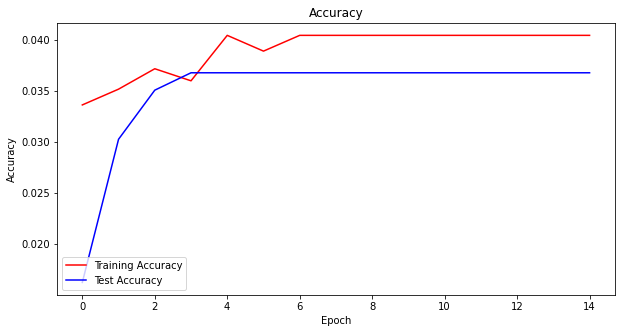

Text(0.5, 1.0, 'Training and Test loss')

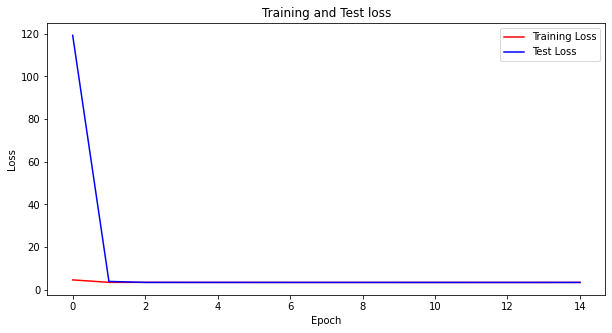

In [7]:
#Plotting the graph for the accuracy of training and testing
fig = plt.figure(figsize=(10,5))
plt.plot(epochs, accuracy, 'r', label="Training Accuracy")
plt.plot(epochs, val_accuracy, 'b', label="Test Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower left')
plt.show()

#Plotting the graph for the loss of training and testing
fig2 = plt.figure(figsize=(10,5))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Test Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test loss')

# Evaluation

In [8]:
scores = model.evaluate(testGen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

312/312 [==============================] - 36s 113ms/step - loss: 3.4963 - accuracy: 0.0368
Accuracy: 3.68%


# Prediction

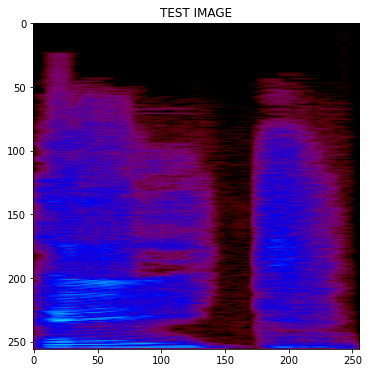

In [9]:
import cv2

test_img_path = "eight.png"
  
img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (256, 256)).reshape(-1, 256, 256, 3)/255.0
  
plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

In [11]:
a = trainGen.class_indices
class_names = list(a.keys())
print("\n",class_names)


 ['_background_noise_', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [10]:
import tensorflow as tf
import pandas as pd

predictions = []

img = tf.keras.preprocessing.image.load_img(test_img_path)
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.keras.preprocessing.image.smart_resize(img, (height, width))
img = tf.reshape(img, (-1, 256, 256, 3))
prediction = model.predict(img/255)
predictions.append(np.argmax(prediction))

print("\nPrediction:")
my_submission = pd.DataFrame({'image_id': test_img_path, 'label':  predictions})
my_submission.to_csv('cnn.csv', index=False)
my_submission.head()

1/1 [==============================] - 1s 664ms/step

Prediction:


,image_id,label
0,eight.png,16


In [12]:
model.save("model.h5")

In [13]:
saved_model = tf.keras.models.load_model("model.h5")

In [15]:
predictions2 = []

img = tf.keras.preprocessing.image.load_img(test_img_path)
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.keras.preprocessing.image.smart_resize(img, (256, 256))
img = tf.reshape(img, (-1, 256, 256, 3))
prediction2 = saved_model.predict(img/255)
predictions2.append(np.argmax(prediction))

print("\nPrediction:")
my_submission = pd.DataFrame({'image_id': test_img_path, 'label':  predictions2})
my_submission.to_csv('cnn.csv', index=False)
my_submission.head()

1/1 [==============================] - 0s 430ms/step

Prediction:


,image_id,label
0,eight.png,16
